# Réseaux de Neurones Convolutifs : Étape par Étape (avec solution)

Bienvenue dans le premier devoir du cours 4 ! Dans cet exercice, vous allez implémenter des couches convolutionnelles (CONV) et de pooling (POOL) en numpy, en incluant à la fois la propagation avant et (facultativement) la rétropropagation.  

À la fin de ce notebook, vous serez capable de : 

* Expliquer l'opération de convolution  
* Appliquer deux types différents d'opérations de pooling  
* Identifier les composants utilisés dans un réseau de neurones convolutionnels (padding, stride, filtre, ...) et comprendre leur rôle  
* Construire un réseau de neurones convolutionnel  

**Notations** :
- Le **superscrit** $[l]$ désigne un objet de la $l^{ème}$ couche.  
    - Exemple : $a^{[4]}$ est l'activation de la $4^{ème}$ couche. $W^{[5]}$ et $b^{[5]}$ sont les paramètres de la $5^{ème}$ couche.

- Le **superscrit** $(i)$ désigne un objet provenant du $i^{ème}$ exemple.  
    - Exemple : $x^{(i)}$ est l'entrée du $i^{ème}$ exemple d'entraînement.  

- Le **subscript** $i$ désigne la $i^{ème}$ entrée d'un vecteur.  
    - Exemple : $a^{[l]}_i$ désigne la $i^{ème}$ entrée des activations dans la couche $l$, en supposant qu'il s'agit d'une couche entièrement connectée (FC).  

- $n_H$, $n_W$ et $n_C$ désignent respectivement la hauteur, la largeur et le nombre de canaux d'une couche donnée. Si vous voulez faire référence à une couche spécifique $l$, vous pouvez également écrire $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$.  
- $n_{H_{prev}}$, $n_{W_{prev}}$ et $n_{C_{prev}}$ désignent respectivement la hauteur, la largeur et le nombre de canaux de la couche précédente. Si vous faites référence à une couche spécifique $l$, cela pourrait également être noté $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$.  

Vous devriez être à l'aise avec `numpy` et/ou avoir suivi les cours précédents de cette spécialisation. Commençons !

## Table des Matières

- [1 - Bibliothèques](#1)  
- [2 - Aperçu de l'exercice](#2)  
- [3 - Réseaux de Neurones Convolutifs](#3)  
    - [3.1 - Zero-Padding (Remplissage par Zéros)](#3-1)  
        - [Exercice 1 - zero_pad](#ex-1)  
    - [3.2 - Étape Unique de Convolution](#3-2)  
        - [Exercice 2 - conv_single_step](#ex-2)  
    - [3.3 - Réseaux de Neurones Convolutifs - Propagation Avant](#3-3)  
        - [Exercice 3 - conv_forward](#ex-3)  
- [4 - Couche de Pooling](#4)  
    - [4.1 - Pooling Avant](#4-1)  
        - [Exercice 4 - pool_forward](#ex-4)  
- [5 - Rétropropagation dans les Réseaux de Neurones Convolutifs (OPTIONNEL / NON NOTÉ)](#5)  
    - [5.1 - Couche de Convolution - Rétropropagation](#5-1)  
        - [5.1.1 - Calcul de dA](#5-1-1)  
        - [5.1.2 - Calcul de dW](#5-1-2)  
        - [5.1.3 - Calcul de db](#5-1-3)  
            - [Exercice 5 - conv_backward](#ex-5)  
    - [5.2 - Couche de Pooling - Rétropropagation](#5-2)  
        - [5.2.1 - Pooling Maximal - Rétropropagation](#5-2-1)  
            - [Exercice 6 - create_mask_from_window](#ex-6)  
        - [5.2.2 - Pooling Moyenne - Rétropropagation](#5-2-2)  
            - [Exercice 7 - distribute_value](#ex-7)  
        - [5.2.3 - Regroupement : Pooling Rétropropagation](#5-2-3)  
            - [Exercice 8 - pool_backward](#ex-8)  

<a name='1'></a>  
## 1 - Bibliothèques  

Commençons par importer toutes les bibliothèques dont vous aurez besoin pour cet exercice.  
- [numpy](www.numpy.org) est la bibliothèque fondamentale pour le calcul scientifique avec Python.  
- [matplotlib](http://matplotlib.org) est une bibliothèque pour tracer des graphiques en Python.  
- `np.random.seed(1)` est utilisé pour maintenir la cohérence de toutes les fonctions aléatoires appelées. Cela facilite l'évaluation de votre travail.  


In [12]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>  
## 2 - Aperçu de l'Exercice  

Vous allez implémenter les blocs de construction d'un réseau de neurones convolutionnel ! Chaque fonction que vous allez coder comportera des instructions détaillées pour vous guider à travers les étapes :  

- Fonctions de convolution, y compris :  
    - Zero Padding (remplissage par zéros)  
    - Fenêtre de convolution  
    - Propagation avant pour la convolution  
    - Rétropropagation pour la convolution (optionnelle)  
- Fonctions de pooling, y compris :  
    - Propagation avant pour le pooling  
    - Création de masque  
    - Distribution des valeurs  
    - Rétropropagation pour le pooling (optionnelle)  

Ce notebook vous demandera d'implémenter ces fonctions à partir de zéro en utilisant `numpy`. Dans le prochain notebook, vous utiliserez les équivalents de ces fonctions dans TensorFlow pour construire le modèle suivant :  

<img src="images/model.png" style="width:800px;height:300px;">  

**Remarque** : Pour chaque fonction de propagation avant, il existe un équivalent en rétropropagation. Ainsi, à chaque étape de votre module de propagation avant, vous stockerez certains paramètres dans un cache. Ces paramètres seront utilisés pour calculer les gradients lors de la rétropropagation.  

<a name='3'></a>  
## 3 - Réseaux de Neurones Convolutifs  

Bien que les frameworks de programmation rendent les convolutions faciles à utiliser, elles restent l’un des concepts les plus difficiles à comprendre en apprentissage profond. Une couche de convolution transforme un volume d'entrée en un volume de sortie de taille différente, comme illustré ci-dessous.  

<img src="images/conv_nn.png" style="width:350px;height:200px;">  

Dans cette partie, vous allez construire chaque étape de la couche de convolution. Vous commencerez par implémenter deux fonctions auxiliaires : une pour le remplissage par zéros (zero padding) et une autre pour le calcul de la fonction de convolution elle-même.  

<a name='3-1'></a>  
### 3.1 - Remplissage par Zéros (Zero-Padding)  

Le remplissage par zéros ajoute des zéros autour de la bordure d'une image :  

<img src="images/PAD.png" style="width:600px;height:400px;">  
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'> : <b>Zero-Padding</b><br> Image (3 canaux, RGB) avec un padding de 2. </center></caption>  

Les principaux avantages du padding sont :  

- Il permet d'utiliser une couche de convolution (CONV) sans nécessairement réduire la hauteur et la largeur des volumes. Cela est important pour construire des réseaux plus profonds, car sinon la hauteur/largeur diminuerait à mesure que l'on passe aux couches plus profondes. Un cas particulier important est la convolution dite "same", où la hauteur/largeur est exactement préservée après une couche.  

- Il permet de conserver davantage d'informations sur les bordures d'une image. Sans padding, très peu de valeurs dans la couche suivante seraient influencées par les pixels situés aux bords d'une image.  

<a name='ex-1'></a>  
### Exercice 1 - zero_pad  
Implémentez la fonction suivante, qui ajoute un remplissage par zéros à toutes les images d'un lot d'exemples \(X\). [Utilisez np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html). Notez que si vous souhaitez remplir un tableau `a` de forme \((5, 5, 5, 5, 5)\) avec `pad = 1` pour la 2e dimension, `pad = 3` pour la 4e dimension, et `pad = 0` pour les autres, vous feriez :  

```python  

a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))  

```  

In [13]:
# GRADED FUNCTION: zero_pad

def zero_pad(X, pad):
    """
    Ajoute un remplissage de zéros à toutes les images du jeu de données X. Le remplissage est appliqué 
    à la hauteur et à la largeur de chaque image, comme illustré dans la Figure 1.
    
    Arguments:
    X -- tableau numpy de forme (m, n_H, n_W, n_C) représentant un lot de m images
    pad -- entier, quantité de remplissage autour de chaque image sur les dimensions verticales et horizontales
    
    Retourne:
    X_pad -- image remplie de forme (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """
    
    # (≈ 1 ligne de code)
    # X_pad = None
    # VOTRE CODE COMMENCE ICI
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)
    # VOTRE CODE SE TERMINE ICI
    
    return X_pad


x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
 All tests passed.


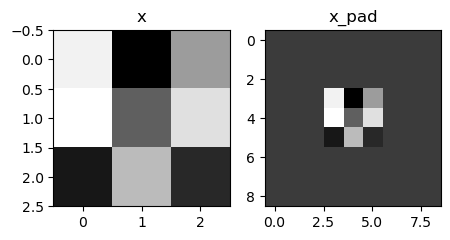

In [14]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 3)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1, 1])
print ("x_pad[1,1] =\n", x_pad[1, 1])

assert type(x_pad) == np.ndarray, "Output must be a np array"
assert x_pad.shape == (4, 9, 9, 2), f"Wrong shape: {x_pad.shape} != (4, 9, 9, 2)"
print(x_pad[0, 0:2,:, 0])
assert np.allclose(x_pad[0, 0:2,:, 0], [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 1e-15), "Rows are not padded with zeros"
assert np.allclose(x_pad[0, :, 7:9, 1].transpose(), [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 1e-15), "Columns are not padded with zeros"
assert np.allclose(x_pad[:, 3:6, 3:6, :], x, 1e-15), "Internal values are different"

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])
zero_pad_test(zero_pad)

Voici la traduction en français de votre texte :

---

### 3.2 - Une étape de convolution

Dans cette partie, vous allez implémenter une seule étape de convolution, dans laquelle vous appliquez le filtre à une seule position de l'entrée. Cela sera utilisé pour construire une unité de convolution, qui :

- Prend un volume d'entrée
- Applique un filtre à chaque position de l'entrée
- Produit un autre volume (généralement de taille différente)

<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : <b>Opération de convolution</b><br> avec un filtre de 3x3 et un pas (stride) de 1 (le pas désigne le nombre de positions que vous déplacez la fenêtre à chaque fois) </center></caption>

Dans une application de vision par ordinateur, chaque valeur dans la matrice à gauche correspond à la valeur d'un seul pixel. Vous convoluez un filtre 3x3 avec l'image en multipliant ses valeurs élément par élément avec la matrice d'origine, puis en les additionnant et en ajoutant un biais. Dans cette première étape de l'exercice, vous allez implémenter une seule étape de convolution, correspondant à l'application d'un filtre à l'une des positions afin d'obtenir une sortie unique de type réel.

Plus tard dans ce cahier, vous appliquerez cette fonction à plusieurs positions de l'entrée pour implémenter l'opération de convolution complète.

### Exercice 2 - `conv_single_step`
Implémentez `conv_single_step()`.

[Indice](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html).

---

**Note** : La variable `b` sera passée sous forme de tableau numpy. Si vous ajoutez un scalaire (un nombre à virgule flottante ou un entier) à un tableau numpy, le résultat sera un tableau numpy. Dans le cas particulier d'un tableau numpy contenant une seule valeur, vous pouvez le convertir en un scalaire en le castant en `float`.

In [15]:
# GRADED FUNCTION: conv_single_step

def conv_single_step(a_slice_prev, W, b):
    """
    Applique un filtre défini par les paramètres W sur une seule tranche (a_slice_prev) de l'activation de sortie 
    de la couche précédente.
    
    Arguments :
    a_slice_prev -- tranche des données d'entrée de forme (f, f, n_C_prev)
    W -- Paramètres de poids contenus dans une fenêtre - matrice de forme (f, f, n_C_prev)
    b -- Paramètres de biais contenus dans une fenêtre - matrice de forme (1, 1, 1)
    
    Retourne :
    Z -- une valeur scalaire, le résultat de la convolution de la fenêtre glissante (W, b) sur une tranche x des données d'entrée
    """

    #(≈ 3 lignes de code)
    # Produit élément par élément entre a_slice_prev et W. Ne pas ajouter encore le biais.
    s = np.multiply(a_slice_prev, W)
    # Somme de toutes les entrées du volume s.
    Z = np.sum(s)
    # Ajouter le biais b à Z. Convertir b en float() pour que Z soit une valeur scalaire.
    b = np.squeeze(b)
    Z = Z + b

    return Z


In [16]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)
conv_single_step_test(conv_single_step)

assert (type(Z) == np.float64 or type(Z) == np.float32), "You must cast the output to float"
assert np.isclose(Z, -6.999089450680221), "Wrong value"

Z = -6.999089450680221
 All tests passed.


**Traduction en français :**

<a name='3-3'></a>
### 3.3 - Réseaux de Neurones Convolutionnels - Pass Forward

Dans le passage forward, vous utiliserez plusieurs filtres et les appliquerez (convoluerez) sur l'entrée. Chaque 'convolution' vous donne une sortie sous forme de matrice 2D. Vous empilerez ensuite ces sorties pour obtenir un volume 3D :



<a name='ex-3'></a>
### Exercice 3 -  conv_forward
Implémentez la fonction ci-dessous pour convoluer les filtres `W` sur une activation d'entrée `A_prev`.  
Cette fonction prend les entrées suivantes :
* `A_prev`, les activations produites par la couche précédente (pour un lot de m entrées) ; 
* Les poids sont représentés par `W`. La taille de la fenêtre du filtre est `f` par `f`.
* Le vecteur de biais est `b`, où chaque filtre a son propre (unique) biais. 

Vous avez également accès au dictionnaire des hyperparamètres, qui contient le stride (pas) et le padding (remplissage). 

**Astuce** : 
1. Pour sélectionner une tranche 2x2 dans le coin supérieur gauche d'une matrice "a_prev" (forme (5,5,3)), vous feriez :
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
Notez que cela donne une tranche 3D de hauteur 2, largeur 2 et profondeur 3. La profondeur correspond au nombre de canaux.  
Cela vous sera utile lorsque vous définirez `a_slice_prev` ci-dessous, en utilisant les index de départ/fin que vous définirez.

2. Pour définir une tranche (`a_slice`), vous devrez d'abord définir ses coins `vert_start`, `vert_end`, `horiz_start` et `horiz_end`. Cette figure pourrait vous être utile pour comprendre comment chaque coin peut être défini à l'aide des variables `h`, `w`, `f` et `s` dans le code ci-dessous.

<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">
<caption><center> <u> <font color='purple'> <b>Figure 3</b> </u><font color='purple'>  : <b>Définition d'une tranche en utilisant les indices de début/fin verticaux et horizontaux (avec un filtre 2x2)</b> <br> Cette figure montre uniquement un seul canal.  </center></caption>


**Rappel** :
    
Les formules reliant la forme de la sortie de la convolution à la forme de l'entrée sont :

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{nombre de filtres utilisés dans la convolution}$$
    



Pour cet exercice, ne vous préoccupez pas de la vectorisation ! Implémentez tout avec des boucles `for`.


#### Astuces supplémentaires (si vous êtes bloqué) :

* Utilisez le découpage de tableaux (par exemple `varname[0:1,:,3:5]`) pour les variables suivantes :  
  `a_prev_pad`, `W`, `b`  
  - Copiez le code de départ de la fonction et exécutez-le à l'extérieur de la fonction définie, dans des cellules séparées.  
  - Vérifiez que le sous-ensemble de chaque tableau correspond à la taille et à la dimension attendues.  
* Pour déterminer comment obtenir les indices `vert_start`, `vert_end`, `horiz_start`, `horiz_end`, rappelez-vous que ce sont les indices de la couche précédente.  
  - Dessinez un exemple de couche précédente avec un remplissage (8 x 8, par exemple), et la couche actuelle (couche de sortie) (2 x 2, par exemple).  
  - Les indices de la couche de sortie sont notés par `h` et `w`.  
* Assurez-vous que `a_slice_prev` a une hauteur, une largeur et une profondeur.
* Rappelez-vous que `a_prev_pad` est un sous-ensemble de `A_prev_pad`.  
  - Réfléchissez à laquelle des deux vous devez utiliser dans les boucles `for`.

In [17]:
# GRADED FUNCTION: conv_forward

def conv_forward(A_prev, W, b, hparameters):
    """
    Implémente la propagation avant pour une fonction de convolution.
    
    Arguments :
    A_prev -- activations de sortie de la couche précédente, 
        tableau numpy de forme (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Poids, tableau numpy de forme (f, f, n_C_prev, n_C)
    b -- Biais, tableau numpy de forme (1, 1, 1, n_C)
    hparameters -- dictionnaire python contenant "stride" et "pad"
        
    Retourne :
    Z -- sortie de la convolution, tableau numpy de forme (m, n_H, n_W, n_C)
    cache -- cache des valeurs nécessaires pour la fonction conv_backward()
    """
    
    # Récupérer les dimensions de A_prev (≈1 ligne)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Récupérer les dimensions de W (≈1 ligne)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Récupérer les informations de "hparameters" (≈2 lignes)
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Calculer les dimensions du volume de sortie CONV en utilisant la formule donnée ci-dessus. 
    # Astuce : utiliser int() pour appliquer l'opération "floor". (≈2 lignes)
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W = int((n_W_prev + 2*pad - f)/stride) + 1
    
    # Initialiser le volume de sortie Z avec des zéros. (≈1 ligne)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Créer A_prev_pad en ajoutant du remplissage à A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):               # boucle sur le lot d'exemples d'entraînement
        a_prev_pad = A_prev_pad[i]          # Sélectionner l'activation remplie du i-ème exemple d'entraînement
        for h in range(n_H):           # boucle sur l'axe vertical du volume de sortie
            # Trouver les indices de début et de fin verticaux du "slice" actuel (≈2 lignes)
            vert_start = stride * h 
            vert_end = vert_start  + f
            
            for w in range(n_W):       # boucle sur l'axe horizontal du volume de sortie
                # Trouver les indices de début et de fin horizontaux du "slice" actuel (≈2 lignes)
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range(n_C):   # boucle sur les canaux (= #filtres) du volume de sortie
                                        
                    # Utiliser les coins pour définir le "slice" (3D) de a_prev_pad (voir astuce ci-dessus). (≈1 ligne)
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    # Convoluer le "slice" (3D) avec le bon filtre W et le biais b, pour obtenir un neurone de sortie. (≈3 lignes)
                    weights = W[:, :, :, c]
                    biases  = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
    
    # Sauvegarder les informations dans "cache" pour la rétropropagation
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache


In [18]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[0,2,1] =\n", Z[0, 2, 1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

conv_forward_test(conv_forward)


Z's mean =
 0.5511276474566768
Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]
 All tests passed.



Enfin, une couche CONV devrait également contenir une activation, auquel cas vous ajouteriez la ligne de code suivante :

```python
# Convoluer la fenêtre pour obtenir un neurone de sortie
Z[i, h, w, c] = ...
# Appliquer l'activation
A[i, h, w, c] = activation(Z[i, h, w, c])
```

Cependant, il n'est pas nécessaire de le faire ici.


## 4 - Couche de Pooling

La couche de pooling (POOL) réduit la hauteur et la largeur de l'entrée. Cela aide à réduire la computation, tout en rendant les détecteurs de caractéristiques plus invariants à leur position dans l'entrée. Les deux types de couches de pooling sont :

- **Max-pooling** : fait glisser une fenêtre de taille ($f, f$) sur l'entrée et stocke la valeur maximale de la fenêtre dans la sortie.
  
- **Average-pooling** : fait glisser une fenêtre de taille ($f, f$) sur l'entrée et stocke la valeur moyenne de la fenêtre dans la sortie.

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

Ces couches de pooling n'ont pas de paramètres pour la rétropropagation à entraîner. Cependant, elles ont des hyperparamètres tels que la taille de la fenêtre $f$. Cela spécifie la hauteur et la largeur de la fenêtre $f \times f$ sur laquelle vous calculeriez un *max* ou une *moyenne*.

### 4.1 - Pooling Avant

Maintenant, vous allez implémenter MAX-POOL et AVG-POOL dans la même fonction.

### Exercice 4 - pool_forward

Implémentez le passage avant de la couche de pooling. Suivez les indices dans les commentaires ci-dessous.

**Rappel** :
Comme il n'y a pas de padding, les formules reliant la forme de sortie du pooling à la forme de l'entrée sont les suivantes :

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_C = n_{C_{prev}}$$

In [19]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implémente le passage avant de la couche de pooling
    
    Arguments :
    A_prev -- Données d'entrée, tableau numpy de forme (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- dictionnaire python contenant "f" et "stride"
    mode -- le mode de pooling que vous souhaitez utiliser, défini comme une chaîne de caractères ("max" ou "average")
    
    Retourne :
    A -- Sortie de la couche de pooling, un tableau numpy de forme (m, n_H, n_W, n_C)
    cache -- Cache utilisé dans le passage arrière de la couche de pooling, contient l'entrée et les hparameters 
    """
    
    # Récupérer les dimensions de la forme de l'entrée
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Récupérer les hyperparamètres depuis "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Définir les dimensions de la sortie
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialiser la matrice de sortie A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    ### DÉBUT DU CODE ###
    for i in range(m):                         # boucle sur les exemples d'entraînement
        a_prev_slice = A_prev[i]
        for h in range(n_H):                     # boucle sur l'axe vertical de la sortie
            # Trouver les indices de début et de fin verticaux du "slice" actuel (≈2 lignes)
            vert_start = stride * h 
            vert_end = vert_start + f
            
            for w in range(n_W):                 # boucle sur l'axe horizontal de la sortie
                # Trouver les indices de début et de fin horizontaux du "slice" actuel (≈2 lignes)
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range (n_C):            # boucle sur les canaux de la sortie
                    
                    # Utiliser les coins pour définir le "slice" actuel sur le i-ème exemple d'entraînement de A_prev, canal c. (≈1 ligne)
                    a_slice_prev = a_prev_slice[vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    # Calculer l'opération de pooling sur le slice. 
                    # Utiliser une instruction if pour différencier les modes. 
                    # Utiliser np.max et np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_slice_prev)
                    else:
                        print(mode + "-type pooling layer NON DEFINI")    
    # FIN DU CODE
    
    # Stocker l'entrée et les hparameters dans "cache" pour pool_backward()
    cache = (A_prev, hparameters)
    
    # Vérifier que la forme de la sortie est correcte
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache


In [20]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])

pool_forward_test(pool_forward)

mode = max
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]

mode = average
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]
 All tests passed.


**Expected output**

```
mode = max
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]

mode = average
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]
```

In [21]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[0] =\n", A[0])
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1] =\n", A[1])

mode = max
A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

mode = average
A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]


**Expected Output:**
    
```
mode = max
A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

mode = average
A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]
```

<font color='blue'>
    
**Voici ce que vous devez retenir**:

* Une convolution extrait des caractéristiques d'une image d'entrée en effectuant un produit scalaire entre les données d'entrée et un tableau 2D de poids (le filtre).
* Le résultat 2D de la convolution est appelé la carte de caractéristiques.
* Une couche de convolution est l'endroit où le filtre glisse sur l'image et effectue le produit scalaire.
    * Cela transforme le volume d'entrée en un volume de sortie de taille différente.
* Le *zero padding* permet de conserver plus d'informations aux bords de l'image et est utile pour construire des réseaux plus profonds, car il permet de construire une couche CONV sans réduire la hauteur et la largeur des volumes.
* Les couches de pooling réduisent progressivement la hauteur et la largeur de l'entrée en faisant glisser une fenêtre 2D sur chaque région spécifiée, puis en résumant les caractéristiques de cette région.

**Félicitations** ! Vous avez maintenant implémenté les passes avant de toutes les couches d'un réseau de convolution. Beau travail !

Le reste de ce carnet est optionnel et ne sera pas noté. Si vous continuez, n'oubliez pas de cliquer sur le bouton "Soumettre" pour soumettre votre travail pour la notation d'abord.


<a name='5'></a>
## 5 - Rétropropagation dans les réseaux de neurones convolutionnels (OPTIONNEL / NON NOTÉ)

Dans les frameworks modernes d'apprentissage profond, vous n'avez qu'à implémenter la passe avant, et le framework s'occupe de la passe arrière, donc la plupart des ingénieurs en apprentissage profond n'ont pas besoin de se soucier des détails de la passe arrière. La passe arrière pour les réseaux convolutionnels est compliquée. Si vous le souhaitez, vous pouvez travailler sur cette portion optionnelle du carnet pour avoir une idée de ce à quoi ressemble la rétropropagation dans un réseau convolutionnel.

Lorsque dans un cours précédent vous avez implémenté un réseau de neurones simple (pleinement connecté), vous avez utilisé la rétropropagation pour calculer les dérivées par rapport au coût afin de mettre à jour les paramètres. De même, dans les réseaux neuronaux convolutionnels, vous pouvez calculer les dérivées par rapport au coût afin de mettre à jour les paramètres. Les équations de rétropropagation ne sont pas triviales et n'ont pas été dérivées dans le cours, mais elles sont brièvement présentées ci-dessous.

<a name='5-1'></a>
### 5.1 - Rétropropagation de la couche convolutionnelle

Commençons par implémenter la rétropropagation pour une couche CONV.

<a name='5-1-1'></a>
#### 5.1.1 - Calcul de dA :
Voici la formule pour calculer \(dA\) par rapport au coût pour un certain filtre \(W_c\) et un exemple d'entraînement donné :

$$dA \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

Où \(W_c\) est un filtre et \(dZ_{hw}\) est un scalaire correspondant au gradient du coût par rapport à la sortie de la couche conv Z à la h-ième ligne et w-ième colonne (correspondant au produit scalaire pris au i-ème déplacement à gauche et j-ème déplacement vers le bas). Notez qu'à chaque fois, vous multipliez le même filtre \(W_c\) par un \(dZ\) différent lors de la mise à jour de \(dA\). Nous faisons cela principalement parce que lors de la propagation avant, chaque filtre est multiplié et additionné à un \(a_{\text{slice}}\) différent. Par conséquent, lors du calcul de la rétropropagation pour \(dA\), vous ajoutez simplement les gradients de tous les \(a_{\text{slices}}\).

En code, à l'intérieur des boucles appropriées, cette formule se traduit par :
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

<a name='5-1-2'></a>
#### 5.1.2 - Calcul de dW :
Voici la formule pour calculer \(dW_c\) (où \(dW_c\) est la dérivée d'un filtre) par rapport à la perte :

$$dW_c  \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} a_{\text{slice}} \times dZ_{hw}  \tag{2}$$

Où \(a_{\text{slice}}\) correspond à la tranche qui a été utilisée pour générer l'activation \(Z_{ij}\). Ainsi, cela nous donne le gradient pour \(W\) par rapport à cette tranche. Puisque c'est le même \(W\), nous allons simplement additionner tous ces gradients pour obtenir \(dW\).

En code, à l'intérieur des boucles appropriées, cette formule se traduit par :
```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

<a name='5-1-3'></a>
#### 5.1.3 - Calcul de db :

Voici la formule pour calculer \(db\) par rapport au coût pour un certain filtre \(W_c\) :

$$db = \sum_h \sum_w dZ_{hw} \tag{3}$$

Comme vous l'avez déjà vu dans les réseaux de neurones de base, \(db\) est calculé en sommant \(dZ\). Dans ce cas, vous additionnez simplement tous les gradients de la sortie de la couche conv (Z) par rapport au coût.

En code, à l'intérieur des boucles appropriées, cette formule se traduit par :
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

<a name='ex-5'></a>
### Exercice 5 - conv_backward

Implémentez la fonction `conv_backward` ci-dessous. Vous devez sommer tous les exemples d'entraînement, filtres, hauteurs et largeurs. Vous devrez ensuite calculer les dérivées en utilisant les formules 1, 2 et 3 ci-dessus. 

In [22]:
def conv_backward(dZ, cache):
    """
    Implémenter la propagation arrière pour une fonction de convolution.
    
    Arguments :
    dZ -- gradient du coût par rapport à la sortie de la couche de convolution (Z), tableau numpy de forme (m, n_H, n_W, n_C)
    cache -- cache des valeurs nécessaires pour conv_backward(), sortie de conv_forward()
    
    Retourne :
    dA_prev -- gradient du coût par rapport à l'entrée de la couche de convolution (A_prev),
               tableau numpy de forme (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient du coût par rapport aux poids de la couche de convolution (W)
          tableau numpy de forme (f, f, n_C_prev, n_C)
    db -- gradient du coût par rapport aux biais de la couche de convolution (b)
          tableau numpy de forme (1, 1, 1, n_C)
    """    
    
    # Récupérer les informations du "cache"
    (A_prev, W, b, hparameters) = cache
    # Récupérer les dimensions de A_prev
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    # Récupérer les dimensions de W
    (f, f, n_C_prev, n_C) = W.shape
    
    # Récupérer les informations des "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Récupérer les dimensions de dZ
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialiser dA_prev, dW, db avec les bonnes dimensions
    dA_prev = np.zeros(A_prev.shape)                          
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)  # b.shape = [1,1,1,n_C]
    
    # Ajouter un padding à A_prev et dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):  # boucle sur les exemples d'entraînement
        
        # Sélectionner l'exemple d'entraînement i de A_prev_pad et dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):  # boucle sur l'axe vertical de la sortie
            for w in range(n_W):  # boucle sur l'axe horizontal de la sortie
                for c in range(n_C):  # boucle sur les canaux de la sortie
                    
                    # Trouver les coins du "slice" courant
                    vert_start = stride * h 
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f

                    # Utiliser les coins pour définir le "slice" de a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Mettre à jour les gradients pour la fenêtre et les paramètres du filtre en utilisant les formules données ci-dessus
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Mettre dA_prev de l'exemple d'entraînement i à da_prev_pad sans padding (Astuce : utiliser X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
    # S'assurer que la forme de la sortie est correcte
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db


In [23]:
# We'll run conv_forward to initialize the 'Z' and 'cache_conv",
# which we'll use to test the conv_backward function
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)

print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

assert type(dA) == np.ndarray, "Output must be a np.ndarray"
assert type(dW) == np.ndarray, "Output must be a np.ndarray"
assert type(db) == np.ndarray, "Output must be a np.ndarray"
assert dA.shape == (10, 4, 4, 3), f"Wrong shape for dA  {dA.shape} != (10, 4, 4, 3)"
assert dW.shape == (2, 2, 3, 8), f"Wrong shape for dW {dW.shape} != (2, 2, 3, 8)"
assert db.shape == (1, 1, 1, 8), f"Wrong shape for db {db.shape} != (1, 1, 1, 8)"
assert np.isclose(np.mean(dA), 1.4524377), "Wrong values for dA"
assert np.isclose(np.mean(dW), 1.7269914), "Wrong values for dW"
assert np.isclose(np.mean(db), 7.8392325), "Wrong values for db"

print("\033[92m All tests passed.")

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838
 All tests passed.


**Expected Output**:
<table>
    <tr>
        <td>
            dA_mean
        </td>
        <td>
            1.45243777754
        </td>
    </tr>
    <tr>
        <td>
            dW_mean
        </td>
        <td>
            1.72699145831
        </td>
    </tr>
    <tr>
        <td>
            db_mean
        </td>
        <td>
            7.83923256462
        </td>
    </tr>

</table>



<a name='5-2'></a>
## 5.2 Couche de Pooling - Passée Arrière

Ensuite, implémentons la passe arrière pour la couche de pooling, en commençant par la couche MAX-POOL. Bien qu'une couche de pooling n'ait pas de paramètres à mettre à jour par la rétropropagation, vous devez tout de même rétropropager le gradient à travers la couche de pooling afin de calculer les gradients pour les couches qui se trouvent avant la couche de pooling.

<a name='5-2-1'></a>
### 5.2.1 Max Pooling - Passée Arrière  

Avant de passer à la rétropropagation de la couche de pooling, vous allez créer une fonction auxiliaire appelée `create_mask_from_window()` qui fait ce qui suit :

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

Comme vous pouvez le voir, cette fonction crée une matrice "masque" qui garde une trace de l'emplacement du maximum dans la matrice. True (1) indique la position du maximum dans X, les autres entrées sont False (0). Vous verrez plus tard que la passe arrière pour le pooling moyen est similaire à cela, mais utilise un masque différent.

<a name='ex-6'></a>
### Exercice 6 - create_mask_from_window

Implémentez `create_mask_from_window()`. Cette fonction sera utile pour la passe arrière du pooling.  
Indices :
- [np.max()]() peut être utile. Elle calcule le maximum d'un tableau.
- Si vous avez une matrice X et un scalaire x : `A = (X == x)` renverra une matrice A de la même taille que X telle que :
```
A[i,j] = True si X[i,j] = x
A[i,j] = False si X[i,j] != x
```
- Ici, vous n'avez pas besoin de considérer les cas où plusieurs maxima existent dans une matrice.


In [24]:
def create_mask_from_window(x):
    """
    Crée un masque à partir d'une matrice d'entrée x, pour identifier l'élément maximum de x.
    
    Arguments:
    x -- Tableau de forme (f, f)
    
    Retourne:
    mask -- Tableau de la même forme que la fenêtre, contenant un True à la position correspondant à l'élément maximum de x.
    """    
    # (≈1 ligne)
    # mask = None
    # DÉBUT DE VOTRE CODE
    mask = (x == np.max(x))
    
    # FIN DE VOTRE CODE
    return mask


In [25]:
np.random.seed(1)
x = np.random.randn(2, 3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x = np.array([[-1, 2, 3],
              [2, -3, 2],
              [1, 5, -2]])

y = np.array([[False, False, False],
     [False, False, False],
     [False, True, False]])
mask = create_mask_from_window(x)

assert type(mask) == np.ndarray, "Output must be a np.ndarray"
assert mask.shape == x.shape, "Input and output shapes must match"
assert np.allclose(mask, y), "Wrong output. The True value must be at position (2, 1)"

print("\033[92m All tests passed.")

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]
 All tests passed.


**Expected Output:** 

<table> 
<tr> 
<td>

**x =**
</td>

<td>

[[ 1.62434536 -0.61175641 -0.52817175] <br>
 [-1.07296862  0.86540763 -2.3015387 ]]

  </td>
</tr>

<tr> 
<td>
mask =
</td>
<td>
[[ True False False] <br>
 [False False False]]
</td>
</tr>


</table>

Pourquoi suivre la position du maximum ? C'est parce que c'est cette valeur d'entrée qui a finalement influencé la sortie, et donc le coût. La rétropropagation calcule les gradients par rapport au coût, donc tout ce qui influence le coût final devrait avoir un gradient non nul. Ainsi, la rétropropagation "propagera" le gradient en arrière vers cette valeur d'entrée particulière qui a influencé le coût.

<a name='5-2-2'></a>Voici la traduction exacte du texte :

---

### 5.2.2 - Average Pooling - Rétropropagation

Dans le max pooling, pour chaque fenêtre d'entrée, toute l'"influence" sur la sortie provenait d'une seule valeur d'entrée — le maximum. Dans l'average pooling, chaque élément de la fenêtre d'entrée a une influence égale sur la sortie. Ainsi, pour implémenter la rétropropagation, vous allez maintenant implémenter une fonction auxiliaire qui reflète cela.

Par exemple, si nous faisions un average pooling dans la passe avant en utilisant un filtre 2x2, alors le masque que vous utiliserez pour la rétropropagation ressemblera à ceci :  
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

Cela implique que chaque position dans la matrice $dZ$ contribue de manière égale à la sortie, car dans la passe avant, nous avons pris une moyenne.

---

### Exercice 7 - distribuer_la_valeur

Implémentez la fonction ci-dessous pour distribuer de manière égale une valeur `dz` à travers une matrice de dimension `shape`.



[Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ones.html)

In [26]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """    
    # Retrieve dimensions from shape (≈1 line)
    (n_H, n_W) = shape
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = np.prod(shape)
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    a = (dz/average)*np.ones(shape)
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE
    return a

In [27]:
a = distribute_value(2, (2, 2))
print('distributed value =', a)


assert type(a) == np.ndarray, "Output must be a np.ndarray"
assert a.shape == (2, 2), f"Wrong shape {a.shape} != (2, 2)"
assert np.sum(a) == 2, "Values must sum to 2"

a = distribute_value(100, (10, 10))
assert type(a) == np.ndarray, "Output must be a np.ndarray"
assert a.shape == (10, 10), f"Wrong shape {a.shape} != (10, 10)"
assert np.sum(a) == 100, "Values must sum to 100"

print("\033[92m All tests passed.")

distributed value = [[0.5 0.5]
 [0.5 0.5]]
 All tests passed.


**Expected Output**: 

<table> 
<tr> 
<td>
distributed_value =
</td>
<td>
[[ 0.5  0.5]
<br\> 
[ 0.5  0.5]]
</td>
</tr>
</table>

<a name='5-2-3'></a>

### 5.2.3 Mettre en pratique : Rétropropagation de Pooling

Vous avez maintenant tout ce dont vous avez besoin pour calculer la rétropropagation sur une couche de pooling.

---

### Exercice 8 - pool_backward

Implémentez la fonction `pool_backward` dans les deux modes (`"max"` et `"average"`). Vous utiliserez à nouveau 4 boucles `for` (itérant sur les exemples d'entraînement, la hauteur, la largeur et les canaux). Vous devez utiliser une instruction `if/elif` pour vérifier si le mode est égal à `'max'` ou `'average'`. Si le mode est égal à `'average'`, vous devez utiliser la fonction `distribute_value()` que vous avez implémentée ci-dessus pour créer une matrice de la même forme que `a_slice`. Sinon, le mode est égal à `'max'`, et vous devrez créer un masque avec `create_mask_from_window()` et le multiplier par la valeur correspondante de `dA`.

In [28]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implémente la rétropropagation de la couche de pooling
    
    Arguments :
    dA -- gradient de la fonction de coût par rapport à la sortie de la couche de pooling, même forme que A
    cache -- cache de la sortie de la propagation avant de la couche de pooling, contient l'entrée de la couche et les hyperparamètres
    mode -- le mode de pooling que vous souhaitez utiliser, défini comme une chaîne de caractères ("max" ou "average")
    
    Retourne :
    dA_prev -- gradient de la fonction de coût par rapport à l'entrée de la couche de pooling, même forme que A_prev
    """
    # Récupérer les informations depuis le cache (≈1 ligne)
    (A_prev, hparameters) = cache
    
    # Récupérer les hyperparamètres de "hparameters" (≈2 lignes)
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Récupérer les dimensions de A_prev et dA (≈2 lignes)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialiser dA_prev avec des zéros (≈1 ligne)
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):  # boucle sur les exemples d'entraînement
        
        # Sélectionner un exemple d'entraînement depuis A_prev (≈1 ligne)
        a_prev = A_prev[i,:,:,:]
        
        for h in range(n_H):  # boucle sur l'axe vertical
            for w in range(n_W):  # boucle sur l'axe horizontal
                for c in range(n_C):  # boucle sur les canaux (profondeur)
        
                    # Trouver les coins du "slice" actuel (≈4 lignes)
                    vert_start  = h * stride
                    vert_end    = h * stride + f
                    horiz_start = w * stride
                    horiz_end   = w * stride + f
                    
                    # Calculer la rétropropagation dans les deux modes.
                    if mode == "max":
                        
                        # Utiliser les coins et "c" pour définir le slice actuel de a_prev (≈1 ligne)
                        a_prev_slice = a_prev[ vert_start:vert_end, horiz_start:horiz_end, c ]
                        
                        # Créer le masque à partir de a_prev_slice (≈1 ligne)
                        mask = create_mask_from_window( a_prev_slice )

                        # Mettre à jour dA_prev en ajoutant (le masque multiplié par l'entrée correspondante de dA) (≈1 ligne)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]
                        
                    elif mode == "average":
                        
                        # Obtenir la valeur da depuis dA (≈2 lignes)
                        da = dA[i, h, w, c]
                        
                        # Définir la forme du filtre comme fxf (≈1 ligne)
                        shape = (f,f)

                        # La distribuer pour obtenir le bon slice de dA_prev. C'est-à-dire ajouter la valeur distribuée de da. (≈1 ligne)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
    
    # Vérifier que la forme de la sortie est correcte
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev


In [29]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
print(A.shape)
print(cache[0].shape)
dA = np.random.randn(5, 4, 2, 2)

dA_prev1 = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev1[1,1] = ', dA_prev1[1, 1])  
print()
dA_prev2 = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev2[1,1] = ', dA_prev2[1, 1]) 

assert type(dA_prev1) == np.ndarray, "Wrong type"
assert dA_prev1.shape == (5, 5, 3, 2), f"Wrong shape {dA_prev1.shape} != (5, 5, 3, 2)"
assert np.allclose(dA_prev1[1, 1], [[0, 0], 
                                    [ 5.05844394, -1.68282702],
                                    [ 0, 0]]), "Wrong values for mode max"
assert np.allclose(dA_prev2[1, 1], [[0.08485462,  0.2787552], 
                                    [1.26461098, -0.25749373], 
                                    [1.17975636, -0.53624893]]), "Wrong values for mode average"
print("\033[92m All tests passed.")

(5, 4, 2, 2)
(5, 5, 3, 2)
mode = max
mean of dA =  0.14571390272918056
dA_prev1[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev2[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
 All tests passed.


**Expected Output**: 

mode = max:
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
dA_prev[1,1] =
</td>
<td>
[[ 0.          0.        ] <br>
 [ 5.05844394 -1.68282702] <br>
 [ 0.          0.        ]]
</td>
</tr>
</table>

mode = average
<table> 
<tr> 
<td>

mean of dA =
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
dA_prev[1,1] =
</td>
<td>
[[ 0.08485462  0.2787552 ] <br>
 [ 1.26461098 -0.25749373] <br>
 [ 1.17975636 -0.53624893]]
</td>
</tr>
</table>

**Félicitations** ! Vous avez terminé l'exercice ainsi que la partie optionnelle. Vous comprenez maintenant comment fonctionnent les réseaux neuronaux convolutifs (CNN) et avez implémenté tous les éléments fondamentaux d'un réseau neuronal. 